In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import torch

## Get the Dataset from file

In [2]:
filename = "../data/"
rawdata = h5py.File(filename+'ViSAPy_nonfiltered.h5','r')

In [3]:
print(rawdata['data'].shape)

(1200001, 102)


## What is the data?

In [4]:
for i in range(5):
    for j in range(6):
        print(rawdata['data'][i][j], end=" ")
    print("\n")

0.004788064 -0.01826318 0.003492297 -0.032078348 -0.010203197 0.0066871587 

0.0037384066 -0.026971504 -0.0045002163 -0.03491524 -0.007150419 0.012898053 

0.0030027581 -0.025864465 -0.0066695386 -0.029838692 -0.0024219453 0.009391305 

-0.003965647 -0.02545898 -0.00031221227 -0.032533586 -0.0057233935 0.01265745 

-0.009700247 -0.02288886 0.0022615287 -0.01949341 2.8031296e-05 0.012613925 



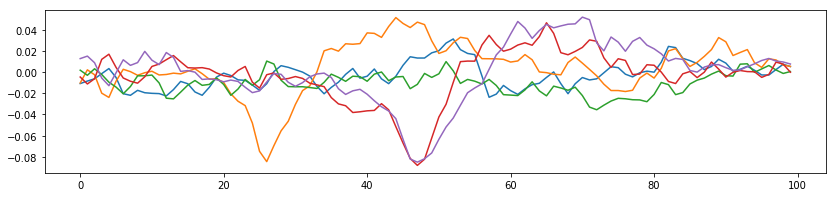

In [5]:
etrode_1 = rawdata['data'][:100, 0]

plt.figure(figsize=(14,3))
for i in range(5):
    etrode_1 = rawdata['data'][550:650, i]
    plt.plot(etrode_1)
plt.show()

## Desigining the autoencoder

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(0)

In [29]:
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, 1536),
                                     nn.ELU(),
                                     nn.Linear(1536, 2048),
                                     nn.ELU(),
                                     nn.Linear(2048, 1024),
                                     nn.ELU(),
                                     nn.Linear(1024, 512),
                                     nn.ELU(),
                                     nn.Linear(512, 256),
                                     nn.ELU(),
                                     nn.Linear(256,64),
                                     nn.ELU())
        self.decoder = nn.Sequential(nn.Linear(64, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 512),
                                     nn.ELU(),
                                     nn.Linear(512, 1024),
                                     nn.ELU(),
                                     nn.Linear(1024, 2048),
                                     nn.ELU(),
                                     nn.Linear(2048, 1536),
                                     nn.ELU(),
                                     nn.Linear(1536, input_size),
                                     nn.ELU())
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec
    
    def forward_numpy(self, x):
        #x = torch.from_numpy(x).float().cuda()
        enc, dec = self.forward(x)
        return dec

In [8]:
from scipy.signal import butter, filtfilt
import numpy as np

fs = 100000.0
cutoff_low = 100
cutoff_high = 10000
order = 4

def butter_pass(cutoff, fs, order=5, ftype='low'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=ftype, analog=False)
    return b, a

def butter_pass_filter(data, cutoff, fs, order=5, ftype='low'):
    b, a = butter_pass(cutoff, fs, order=order, ftype=ftype)
    y = filtfilt(b, a, data)
    return y

In [12]:
length = 1000
max_length = rawdata['data'].shape[0] - length
base_feat_length = 101
features = 200000
np.random.seed(5132)

electrode_data = np.zeros([length, features])

for i in range(features):
    start = np.random.randint(0, max_length)
    selected_trode = np.random.randint(0, base_feat_length)
    electrode_data[:, i] = rawdata['data'][start:start+length, selected_trode]
    electrode_data[:, i ] = butter_pass_filter(electrode_data[:, i], cutoff_high, fs, order, 'low')
    electrode_data[:, i ] = butter_pass_filter(electrode_data[:, i], cutoff_low, fs, order, 'high')
#print(electrode_data)

In [4]:
#np.save('mydata_1000_cond', electrode_data)
electrode_data = np.load('mydata_1000_cond.npy')
#print(electrode_data.shape[1])
train_lim = int(0.8*electrode_data.shape[1])
electrode_data_train = electrode_data[:, :train_lim]
electrode_data_test = electrode_data[:, train_lim:]

In [30]:
import random

def train(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[1]), batch_size)
        for feats in selected:
            x = input_data[:, feats]
            #print(x)
            #x = np.append(x, 1)
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            out = model.forward_numpy(x)
            out = torch.tensor(out).float().cuda()
            #print(type(torch.from_numpy(out).float().cuda()), type(x))
            loss = criterion(out, x)
            #print(loss)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], loss:{:.7f}'.format(num_epoch + 1, epoch_range, loss.data[0]))
    return out

In [31]:
epoch_range = 25
batch_size = 400
learning_rate = 0.0001
length = 1000

model = autoencoder(length).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

out = train(model, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

/home/sambit/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/25], loss:0.0112571
epoch [2/25], loss:0.0110242
epoch [3/25], loss:0.0091538
epoch [4/25], loss:0.0122134
epoch [5/25], loss:0.0130778
epoch [6/25], loss:0.0078643
epoch [7/25], loss:0.0091459
epoch [8/25], loss:0.0087128
epoch [9/25], loss:0.0123776
epoch [10/25], loss:0.0115382
epoch [11/25], loss:0.0094126
epoch [12/25], loss:0.0104289
epoch [13/25], loss:0.0114825
epoch [14/25], loss:0.0094216
epoch [15/25], loss:0.0087781
epoch [16/25], loss:0.0114583
epoch [17/25], loss:0.0119642
epoch [18/25], loss:0.0098325
epoch [19/25], loss:0.0081034
epoch [20/25], loss:0.0086373
epoch [21/25], loss:0.0103451
epoch [22/25], loss:0.0096622
epoch [23/25], loss:0.0101746
epoch [24/25], loss:0.0122264
epoch [25/25], loss:0.0112115


In [ ]:
out = (out.data).cpu().numpy()
print(out.shape)

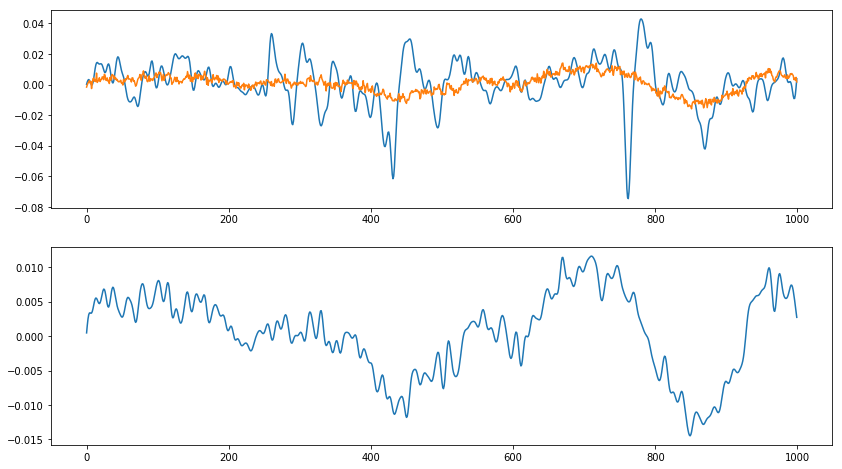

In [41]:
n = [50]#[1, 30, 45, 50, 65]
lim = 100
# input_list = []
# output_list = []
plt.figure(figsize=(14,8))
cutoff_low = 100
cutoff_high = 10000

for i in n:
    data = electrode_data_test[:1000, i]
    #input_list.append(data)
    #data = np.append(data, 1)
    #print(data)
    data = torch.from_numpy(data).float().cuda()
    o = model.forward_numpy(data).cuda()
    o = (o.data).cpu().numpy()
    conditioned_signal_lowpass = butter_pass_filter(o, cutoff_high, fs, order, 'low')
    conditioned_signal = butter_pass_filter(conditioned_signal_lowpass, cutoff_low, fs, order, 'high')
#     output_list.append(o[:100])
    #print(electrode_data[:30, 0]-o[:30])
    #print(o)
    plt.subplot(211)
    plt.plot(electrode_data_test[:1000, i])
    #plt.subplot(312)
    plt.plot(o[:1000])
    plt.subplot(212)
    plt.plot(conditioned_signal[:1000])
plt.show()

NameError: name 'conditioned_signal_2' is not defined

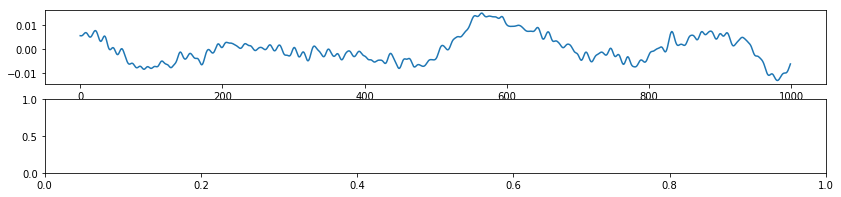

In [35]:
from scipy.signal import butter, filtfilt

def butter_highpass(cutoff, fs, order=5, ftype='low'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=ftype, analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5, ftype='low'):
    b, a = butter_highpass(cutoff, fs, order=order, ftype=ftype)
    y = filtfilt(b, a, data)
    return y

fs = 100000.0
cutoff_low = 1
cutoff_high = 10000
order = 4
conditioned_signal_lowpass = butter_highpass_filter(o, cutoff_high, fs, order, 'low')
conditioned_signal = butter_highpass_filter(conditioned_signal, cutoff_low, fs, order, 'high')
plt.figure(figsize=(14,3))
plt.subplot(211)
plt.plot(conditioned_signal_lowpass)
plt.subplot(212)
plt.plot(conditioned_signal_2)
plt.show()

In [127]:
model.encoder[0].weight = model.encoder[0].weight*100
print(x)

TypeError: cannot assign 'torch.cuda.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [44]:
from scipy.interpolate import interp1d

def downsample_by_interp(shape, jitter_size):
    x = np.arange(len(shape))
    down_x = x[::3]
    intrp = interp1d(x, shape, 'cubic', fill_value='extrapolate')
    return intrp(down_x + (np.random.random()-.5)*jitter_size)

down_sampled = 

downsampled = np.array([downsample_by_interp(s, 3) for s in train_data])
print(downsampled.shape)

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  

[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  6  9 12 15 18 21 24 27]
[ 0  3  